# Correlation and Regression to the Mean

In ["Thinking, Fast and Slow"](https://en.wikipedia.org/wiki/Thinking,_Fast_and_Slow) by Daniel Kahneman, while explaining regression to the mean he writes,

> Highly intelligent women tend to marry men who are less intelligent than they are.

is equivalent to the statement

> The correlation between the intelligence scores of spouses is less then perfect.

He further clarifies his point.

> If the correlation between the intelligence of spouses is less than perfect (and if men and women on average do not differ in intelligence), then it is a mathematical inevitability that highly intelligent women will be married to husbands who are on average less intelligent than they are (and vice versa, of course). The observed regression to the mean cannot be more interesting or more explainable than the imperfect correlation.

Now I understand the point he is making and his book is not a textbook.
If married couple's intelligence follows a bivariate normal distribution (which is likely I imagine) then this is true.
I think it would be interesting to try generating discrete bivariate distribtions to see if I can find counter examples that show that Kahneman's statements are not equivalent.

The tool I'll be using to do this is [convex optimization](https://en.wikipedia.org/wiki/Convex_optimization), although all the problems I'm doing are a subset, specifically [linear programming](https://en.wikipedia.org/wiki/Linear_programming).
My tool of choice in python is [cvxpy](http://www.cvxpy.org/en/latest/).

In [1]:
%matplotlib inline
figsize(12, 8)
import cvxpy as cvx

I need to compute the [correlation coefficient](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient) over discrete bivariate distributions to check if the claims have been violated.
I'm defining [covariance](https://en.wikipedia.org/wiki/Covariance) and correlation here.

In [2]:
def covariance(mat):
    XY = np.maximum(mat.value.A, 0)
    N = len(XY)
    XYv = np.outer(np.arange(N), np.arange(N))
    EXY = (XY * XYv).sum()

    EX = np.dot(XY.sum(axis=1), np.arange(N))
    EY = np.dot(XY.sum(axis=0), np.arange(N))

    return EXY - EX*EY

def correlation(mat):
    XY = np.maximum(mat.value.A, 0)
    N = len(XY)
    cov = covariance(mat)
    
    xx = XY.sum(axis=1)
    yy = XY.sum(axis=0)
    
    EX = np.dot(xx, np.arange(N))
    EY = np.dot(yy, np.arange(N))
    
    varX = np.dot(xx, (np.arange(N) - EX)**2)
    varY = np.dot(yy, (np.arange(N) - EY)**2)
        
    return cov / np.sqrt(varX * varY)

I'm going to generate a 20x20 matrix to represent the bivariate distribution.
Columns will represent wife intelligence and rows will represent husband intelligence, so bright people will be in the last 10 columns and rows, while dim people will be in the first 10 columns and rows.
I also create a few expressions I'll be using in the linear program, such as the [marginal probabilities](https://en.wikipedia.org/wiki/Marginal_distribution) and [expected values](https://en.wikipedia.org/wiki/Expected_value) of bright women (women who fall in the last 10 columns).

In [3]:
N = 20
# joint probability matrix
# rows are husband intelligence
# columns are wife intelligence
prob = cvx.Variable(N, N)

# marginal probability distributions
prob_women = (np.ones(N) * prob).T
prob_men = prob * np.ones(N)

# expected value of men and women intelligence
exp_women = prob_women.T * np.arange(N)
exp_men = prob_men.T * np.arange(N)

# expected values of smart women and men given they are married to smart women
exp_bright_women = np.arange(N//2, N) * prob_women[N//2:] / .5
exp_men_given_bright_women = np.arange(N) * prob[:, N//2:] * np.ones(N//2) / .5

I'll construct the constraints, first the probability matrix must sum to 1 and must be nonnegative.

In [4]:
constraints = [cvx.sum_entries(prob) == 1., prob >= 0]

In order to make the conditional expectation expressions correct, I need to make the probability of bright women and men equal to the probability of dim women and men.
To make them equal, I add a median constraint.

In [5]:
constraints.extend([cvx.sum_entries(prob_women[:N//2]) == cvx.sum_entries(prob_women[N//2:]),
                    cvx.sum_entries(prob_men[:N//2]) == cvx.sum_entries(prob_men[N//2:])])

Now Kahneman says this is the case "if men and women on average do not differ in intelligence", I'm going to interpret this as the expected women's intelligence is equal to the expected men's intelligence.

In [6]:
constraints.append(exp_women == exp_men)

That's enough constraints to get us started.
Now there is the question of what quantity to maximize since this is an opimization problem.
The objective will be to subtract the expected intelligence of bright women from the expected intelligence of men that have married bright women.
If this quantity is positive then Kahneman's "regression to the mean" will be violated.

In [7]:
objective = cvx.Maximize(exp_men_given_bright_women - exp_bright_women)

Now it's a simple matter of running it through cxvpy by giving it the objective and the constraints and letting it solve the problem.

In [8]:
problem = cvx.Problem(objective, constraints)
problem.solve()
problem.status

'optimal'

If the status is "optimal" that means all constraints are met and the problem is solved.
The status is "optimal" so we can proceed with analysis.
Let's first check the objective value.

In [9]:
objective.value

8.9999999993702

It's 9!
The only way this can happen is if all the bright women (women above or equal to 10 intelligence) are 10 and they are all married to men with intelligence of 19.
Let's look at the probability distributions to see what happened.

In [10]:
def plot_marginal(marginal):
    plt.plot(100. * marginal.value, '-o')
    plt.ylabel('probability (percentage)')
    plt.xlabel('intelligence')
    plt.ylim(0, 100. * marginal.value.max() * 1.1)

def plot_joint(joint):
    mat = np.maximum(100. * joint.value.A, 0)
    #mat = np.log(np.maximum(np.log(joint.value.A), 0) + 1)
    plt.imshow(mat, interpolation='none')
    plt.colorbar()
    plt.ylabel('men')
    plt.xlabel('women')
    plt.grid(False)

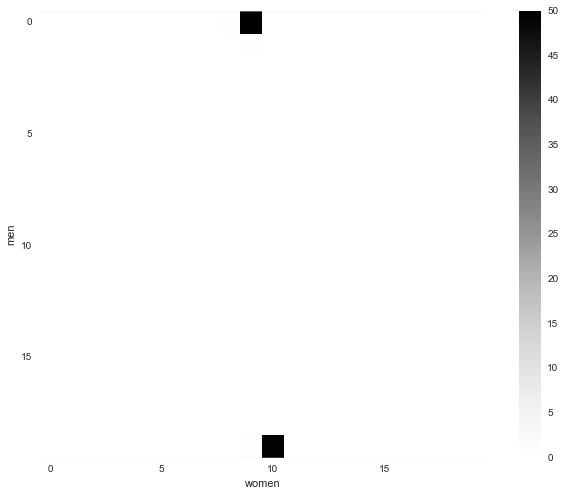

In [11]:
plot_joint(prob)

We can see here that all the mass for bright women is of women with 10 intelligence marrying men of 19 intelligence.
Let's see what happened to the marginals. 

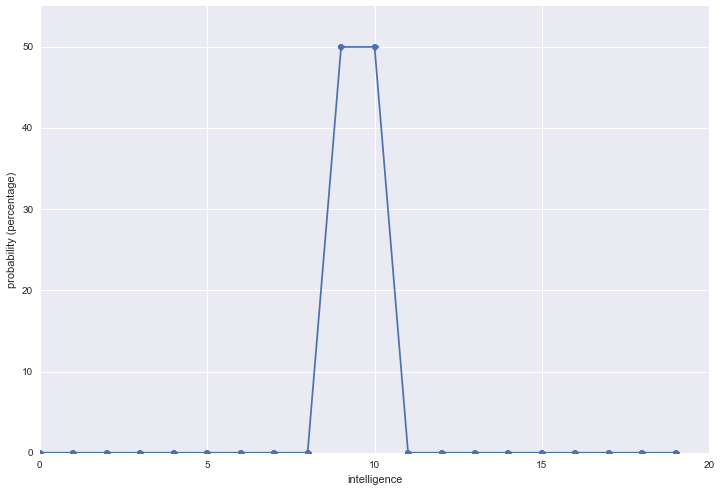

In [12]:
plot_marginal(prob_women)

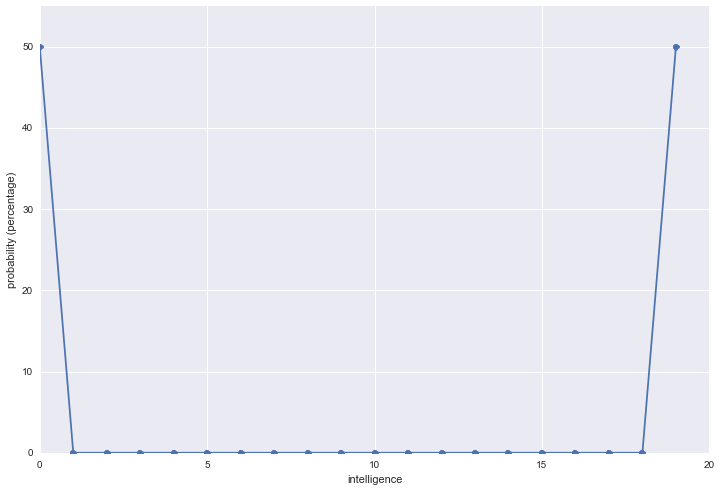

In [13]:
plot_marginal(prob_men)

We see now that the marginal distributions for both men and women are quite binary.

In [14]:
correlation(prob)

0.99999999716406629

It is perfectly correlated.
Let's add a constraint to make the distribution look [unimodal](https://en.wikipedia.org/wiki/Unimodality) since I think that would be a better representation of an intelligence distribution.
To do this I'll add a constraints that will enforce the maximum value to occur at 9 or 10 and make it unimodal.

In [15]:
prob_const = 0
constraints.extend([cvx.diff(prob_men[:N//2]) >= prob_const,
                    cvx.diff(prob_women[:N//2]) >= prob_const,
                    cvx.diff(prob_men[N//2:]) <= -prob_const,
                    cvx.diff(prob_women[N//2:]) <= -prob_const])

In [16]:
problem = cvx.Problem(objective, constraints)
problem.solve()
problem.status

'optimal'

In [17]:
objective.value

4.49999999907409

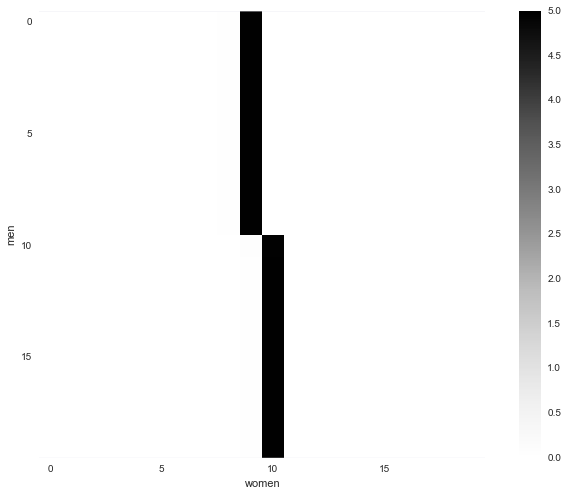

In [18]:
plot_joint(prob)

This is a little more interesting, the objective has been cut in half and we have full support about the men distribution.

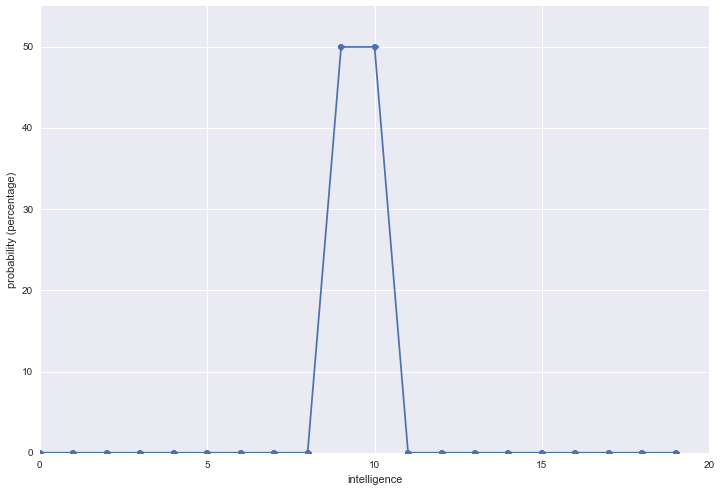

In [19]:
plot_marginal(prob_women)

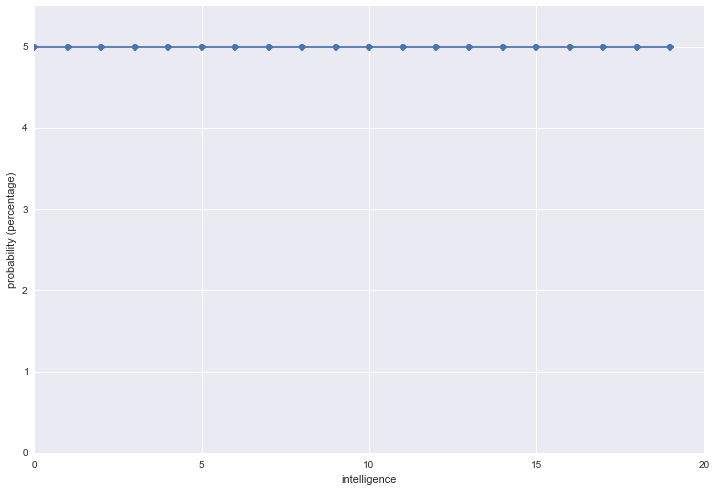

In [20]:
plot_marginal(prob_men)

We see here that the men's marginal distribution is flat.

In [21]:
correlation(prob)

0.86710996372576221

Furthermore, the joint probability is of course not perfectly correlated, although it is still highly correlated.
At this point it may be fair to say we have found a contradiction.
Let's continue anyway with a few more constraints.
I think it's fair to have the marginal distributions be the same and not just the average, so let's add that constraint.

In [22]:
constraints.append(prob_women == prob_men)

In [23]:
problem = cvx.Problem(objective, constraints)
problem.solve()
problem.status

'optimal'

In [24]:
objective.value

1.3237944074262487e-10

Okay this is effectively zero.
So with the added constraint the expected intelligence of a bright women's husband is the same as her own.

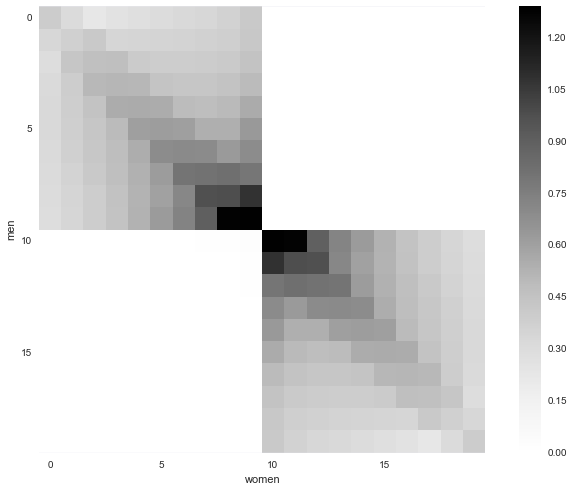

In [25]:
plot_joint(prob)

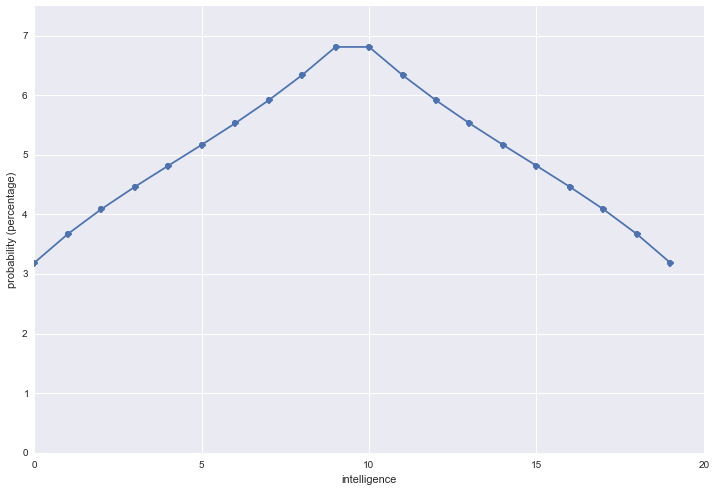

In [26]:
plot_marginal(prob_women)

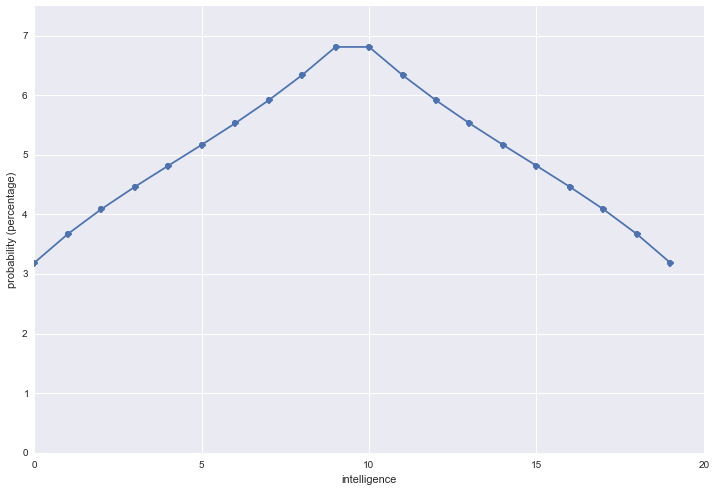

In [27]:
plot_marginal(prob_men)

In [28]:
correlation(prob)

0.75440080814813226

This also violates Kahneman's "regression to the mean" since we have a joint distribution that is not perfectly correlated yet bright women are just as smart as their husbands on average.

From the wikipedia page on [regression to the mean](https://en.wikipedia.org/wiki/Regression_toward_the_mean) the definition is more restrictive.
It states that for a bivariate distribution to exhibit regression to the mean the following must hold,

$$\mu \le E[X_2 | X_1 = c] < c$$

where $\mu$ is the mean value and the opposite inequalities hold when $c < \mu$.
This would be easier to violate than the current objective because only one inequality needs to be violated i.e. one $c$ to not satisfy regression to the mean.
For fun though, I'll try to violate them all by adding those as constraints.

In [29]:
constraints.extend([(np.arange(N) * prob[:, i]) >= cvx.sum_entries(i * prob[:, i]) for i in range(N//2, N)])

And also to below average intelligence women.

In [30]:
constraints.extend([(np.arange(N) * prob[:, i]) <= cvx.sum_entries(i * prob[:, i]) for i in range(N//2)])

In [31]:
problem = cvx.Problem(objective, constraints)
problem.solve()
problem.status

'optimal'

In [32]:
objective.value

1.332818300170402e-10

Again this is zero.

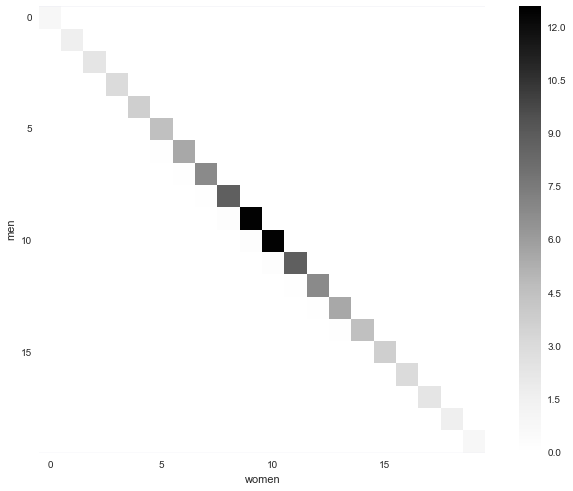

In [33]:
plot_joint(prob)

Now we see that this effectively makes the joint probability perfectly correlated.

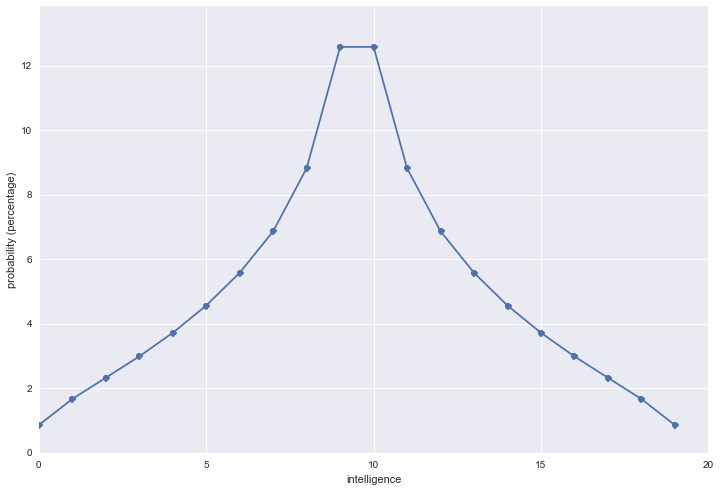

In [34]:
plot_marginal(prob_women)

In [35]:
correlation(prob)

0.99999999987333121

Now we see what happens when we try to make *every* married husband **not** regress to the mean.
It is an impossibility and we end up with a perfectly correlated distribution.
And I can check that the last 20 inequality constraints are in fact equivalent.

In [36]:
difference = [((np.arange(N) * prob[:, i]) -
               cvx.sum_entries(i * prob[:, i])).value for i in range(N)]
np.allclose(difference, 0)

True

*This blog post was written entirely in the [IPython](http://ipython.org) Notebook.
The full notebook can be downloaded [here](https://raw.githubusercontent.com/jwkvam/jwkvam.github.io/master/notebooks/kahneman_regression.ipynb) or viewed statically [here](http://nbviewer.ipython.org/url/jwkvam.github.io/notebooks/kahneman_regression.ipynb).
You can find me on [GitHub](https://github.com/jwkvam), [LinkedIn](https://linkedin.com/in/jwkvam) and [Twitter](https://twitter.com/jwkvam).*
